# Adaptive heuristics : Regret Matching
## Théo Delemazure

This notebook shows an implementation of the regret matching dynamics presented in the paper "Adaptive heuristics" : https://www.jstor.org/stable/3598879?seq=1#metadata_info_tab_contents

Some imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [59]:
N_players = 4
N_actions = 3
periods = 10000

Functions to create game and get payoffs

In [60]:
# Create a random game with N_players players and N_actions possible actions for each player
def create_game(N_players,N_actions):
    possible_plays = N_actions**N_players
    return np.random.rand(possible_plays,N_players)*10


def get_action_index(N_actions,actions):
    i = 0
    for action in actions[::-1]:
        i = i*N_actions + action
    return i

# Return the payoff of every candidate when the action "actions" is played
def get_payoff(N_actions,game,actions):
    action_index = get_action_index(N_actions,actions)
    return game[action_index]

# Return payoff of i if only devy from the actions being played
def get_payoff_i(N_actions,game,actions,i):
    payoff_i = np.zeros(N_actions)
    actions_modified = actions.copy()
    for action in range(N_actions):
        actions_modified[i] = action
        payoff_i[action] = get_payoff(N_actions,game,actions_modified)[i]
    return payoff_i

# Return regret of i if actions being played
def get_regret(N_actions,game,actions,i):
    payoff_i = get_payoff_i(N_actions,game,actions,i)
    return np.max(payoff_i) - payoff_i[actions[i]]


## Random Strategy

In [61]:
def random_strategy(N_players,N_actions,periods):
    game = create_game(N_players,N_actions)
    regret = np.zeros((N_players,periods+1))
    for t in range(periods):
        actions = np.random.randint(0,N_actions,N_players)
        for i in range(N_players):
            regret[i,t+1] = regret[i,t] + get_regret(N_actions,game,actions,i)
    return regret


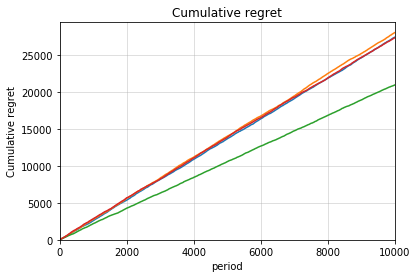

In [62]:
regret = random_strategy(N_players,N_actions,periods)

for reg in regret:
    plt.plot(reg)
plt.title("Cumulative regret")
plt.ylabel("Cumulative regret")
plt.xlabel("period")
plt.xlim(0,periods)
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

We obtain linear regret, which is not really surprising as the strategy choose the action randomly

## Regret Matching

In [63]:
def regret_matching(N_players,N_actions,periods):
    game = create_game(N_players,N_actions)
    c = 1/(N_actions*np.max(game))
    regret = np.zeros((N_players,periods+1))
    pairwise_regret = np.zeros((N_players,N_actions,N_actions))
    tracking = np.zeros((periods))
    for t in range(periods):
        # Choose actions beeing played
        if t == 0: # At t0 choose at random
            actions = np.random.randint(0,N_actions,N_players)
        else: # Otherwise use regret matching algorithm
            for i in range(N_players):
                probability = (pairwise_regret[i,actions[i]]*c).clip(min=0)
                probability[actions[i]] = 1 - np.sum(probability)
                actions[i] = np.random.choice(np.arange(N_actions),p=probability)
        # Compute regret and pairwise regret for every players
        pairwise_regret = pairwise_regret*(1-1/(t+1))
        for i in range(N_players):
            regret[i,t+1] = regret[i,t] + get_regret(N_actions,game,actions,i)
            payoff_i = get_payoff_i(N_actions,game,actions,i)
            pairwise_regret[i,actions[i]] += (payoff_i-payoff_i[actions[i]])/(t+1)
        
        tracking[t] = pairwise_regret.clip(min=0).sum()/(N_actions*(N_actions-1))
    return tracking,regret

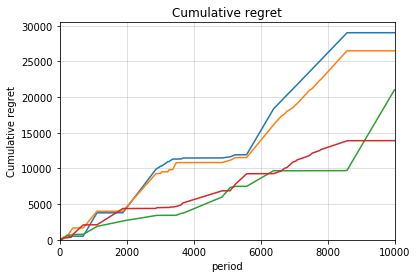

In [67]:
tracked,regret = regret_matching(N_players,N_actions,periods)
for reg in regret:
    plt.plot(reg)
plt.title("Cumulative regret")
plt.ylabel("Cumulative regret")
plt.xlabel("period")
plt.xlim(0,periods)
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

Regrets end up constent or linear increase, because if we switch to a bad action, it is hard to go back the best option (low probability)

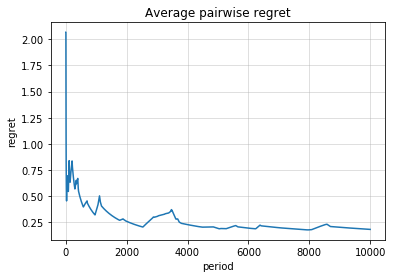

In [68]:
plt.plot(tracked)
plt.title("Average pairwise regret")
plt.ylabel("regret")
plt.xlabel("period")
plt.grid(alpha=0.5)
plt.show()

The average pairwise regret, as defined in the paper, tends to 0 with the time

## Generalized Regret Matching

Above, an implementation of generalized regret matching with the function f used :

\begin{align}
f(R_j(k)) = K\times\frac{R_j(k)}{\sum_i^n R_j(i)}
\end{align}
with $K$ a chosen constant, for instance $0.3$. The constant $K \in [0,1]$ determine the probability of switching the action when at least one regret is not null. 

In [69]:
def generalized_regret_matching(N_players,N_actions,periods,f):
    game = create_game(N_players,N_actions)
    c = 1/(N_actions*np.max(game))
    regret = np.zeros((N_players,periods+1))
    pairwise_regret = np.zeros((N_players,N_actions,N_actions))
    tracking = np.zeros((periods))
    for t in range(periods):
        # Choose actions beeing played
        if t == 0: # At t0 choose at random
            actions = np.random.randint(0,N_actions,N_players)
        else: # Otherwise use regret matching algorithm
            for i in range(N_players):
                probability = f(pairwise_regret[i,actions[i]]) # we use the function f
                probability[actions[i]] = 1 - np.sum(probability)
                actions[i] = np.random.choice(np.arange(N_actions),p=probability)
        # Compute regret and pairwise regret for every players
        pairwise_regret = pairwise_regret*(1-1/(t+1))
        for i in range(N_players):
            regret[i,t+1] = regret[i,t] + get_regret(N_actions,game,actions,i)
            payoff_i = get_payoff_i(N_actions,game,actions,i)
            pairwise_regret[i,actions[i]] += (payoff_i-payoff_i[actions[i]])/(t+1)
        
        tracking[t] = pairwise_regret.clip(min=0).sum()/(N_actions*(N_actions-1))
    return tracking,regret

In [73]:
switch_proba = 0.3
def partial_softmax(tab):
    proba = tab.clip(min=0)
    if np.sum(proba) == 0:
        return proba
    return switch_proba*proba/np.sum(proba)

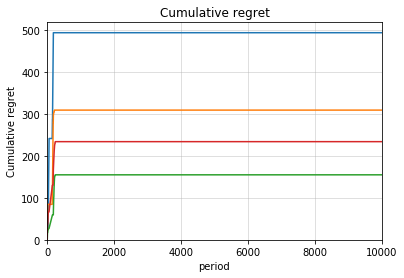

In [82]:
tracked,regret = generalized_regret_matching(N_players,N_actions,periods,partial_softmax)
for reg in regret:
    plt.plot(reg)
plt.title("Cumulative regret")
plt.ylabel("Cumulative regret")
plt.xlabel("period")
plt.xlim(0,periods)
plt.ylim(0)
plt.grid(alpha=0.5)
plt.show()

The players quickly find the best action to play

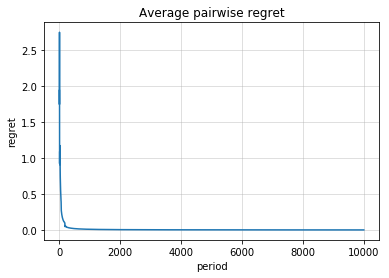

In [83]:
plt.plot(tracked)
plt.title("Average pairwise regret")
plt.ylabel("regret")
plt.xlabel("period")
plt.grid(alpha=0.5)
plt.show()

The average pairwise regret vanish in few periods.